<a href="https://colab.research.google.com/github/tarunsudab/StockPricePredictions/blob/main/MarketPredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Data Collection

In [ ]:
stocks = {}

# Prediction
stocks['AAPL'] = pd.read_csv("AAPL.csv")

# Peer Context
stocks['AMZN'] = pd.read_csv("AMZN.csv")
stocks['MSFT'] = pd.read_csv("MSFT.csv")

# Market
stocks['SPY'] = pd.read_csv("SPY.csv")

# Tech Context
stocks['XLK'] = pd.read_csv("XLK.csv")
stocks['QQQ'] = pd.read_csv("QQQ.csv")

# Rates Proxy
stocks['TLT'] = pd.read_csv("TLT.csv")
stocks['IEF'] = pd.read_csv("IEF.csv")

for s in stocks:
  stock = stocks[s]

  # Replace $ and other special characters to convert to decimal
  stock = stock.replace({',': '', '\s+': '', '\$': ''}, regex=True)

  # Convert date to datetime
  stock['Date'] = pd.to_datetime(stock['Date'], errors='coerce')

  # Convert columns to decimals
  for col in stock.columns:
    if col != 'Date':
      stock[col] = pd.to_numeric(stock[col], errors='coerce')

  # Sort the values in ascending for later on
  stock.sort_values('Date', inplace=True, ascending=True)
  stock.set_index('Date', inplace=True)
  stocks[s] = stock
  print(stock.head())

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3036036408.py:25: SyntaxWarning: invalid escape sequence '\s'
  stock = stock.replace({',': '', '\s+': '', '\$': ''}, regex=True)
/tmp/ipython-input-3036036408.py:25: SyntaxWarning: invalid escape sequence '\$'
  stock = stock.replace({',': '', '\s+': '', '\$': ''}, regex=True)


            Close/Last     Volume    Open    High      Low
Date                                                      
2020-12-15     127.880  157572300  124.34  127.90  124.130
2020-12-16     127.810   98208590  127.41  128.37  126.560
2020-12-17     128.700   94359810  128.90  129.58  128.045
2020-12-18     126.655  192541500  128.96  129.10  126.120
2020-12-21     128.230  121251600  125.02  128.31  123.449
            Close/Last     Volume      Open      High       Low
Date                                                           
2020-12-15    158.2560   66473720  159.0505  159.4250  156.5245
2020-12-16    162.0480   88552320  158.8005  162.3500  158.1840
2020-12-17    161.8040   69486940  162.5000  163.1755  161.0500
2020-12-18    160.0825  119914260  162.1995  162.4710  158.5800
2020-12-21    160.3090   76736920  160.0005  161.3483  158.3000
            Close/Last    Volume     Open    High       Low
Date                                                       
2020-12-15      214

In [ ]:
# Put all the values for all the stocks in 1 dataframe for comparison
close_prices = pd.DataFrame()

for stock, data in stocks.items():
  close_prices[stock] = data['Close/Last']

close_prices.head()

,AAPL,AMZN,MSFT,SPY,XLK,QQQ,TLT,IEF
Date,,,,,,,,
2020-12-15,127.880,158.2560,214.13,369.59,63.415,307.29,157.80,119.96
2020-12-16,127.810,162.0480,219.28,370.17,63.845,308.98,157.38,119.86
2020-12-17,128.700,161.8040,219.42,372.24,64.350,311.00,156.80,119.70
2020-12-18,126.655,160.0825,218.59,369.18,64.125,310.06,156.33,119.60
2020-12-21,128.230,160.3090,222.59,367.86,64.040,308.92,156.95,119.68


In [ ]:
# Calculate percent change for each stock

change = close_prices.pct_change().dropna()
change.columns = [f"{s}_change" for s in change.columns]

change.head()

,AAPL_change,AMZN_change,MSFT_change,SPY_change,XLK_change,QQQ_change,TLT_change,IEF_change
Date,,,,,,,,
2020-12-16,-0.000547,0.023961,0.024051,0.001569,0.006781,0.005500,-0.002662,-0.000834
2020-12-17,0.006963,-0.001506,0.000638,0.005592,0.007910,0.006538,-0.003685,-0.001335
2020-12-18,-0.015890,-0.010639,-0.003783,-0.008221,-0.003497,-0.003023,-0.002997,-0.000835
2020-12-21,0.012435,0.001415,0.018299,-0.003575,-0.001326,-0.003677,0.003966,0.000669
2020-12-22,0.028464,0.000106,0.006065,-0.001685,0.008666,0.002719,0.005161,0.001671


In [ ]:
target_stock = 'AAPL'
target_col = f"{target_stock}_change"

# Find if the next day change is positive or negative
next_day_change = change[target_col].shift(-1)
#print(next_day_change)

# Convert the change into binary where 0 means negative change and 1 means positive change
target = (next_day_change > 0).astype(int)
print(target)

Date
2020-12-16    1
2020-12-17    0
2020-12-18    1
2020-12-21    1
2020-12-22    0
             ..
2025-12-08    0
2025-12-09    1
2025-12-10    0
2025-12-11    1
2025-12-12    0
Name: AAPL_change, Length: 1254, dtype: int64


In [ ]:
# Inputted the target into a new DF so that we can split it into training and test data
model_df = change.copy()
model_df[f"{target_stock}_target"] = target
model_df = model_df.dropna()
model_df.head()

,AAPL_change,AMZN_change,MSFT_change,SPY_change,XLK_change,QQQ_change,TLT_change,IEF_change,AAPL_target
Date,,,,,,,,,
2020-12-16,-0.000547,0.023961,0.024051,0.001569,0.006781,0.005500,-0.002662,-0.000834,1
2020-12-17,0.006963,-0.001506,0.000638,0.005592,0.007910,0.006538,-0.003685,-0.001335,0
2020-12-18,-0.015890,-0.010639,-0.003783,-0.008221,-0.003497,-0.003023,-0.002997,-0.000835,1
2020-12-21,0.012435,0.001415,0.018299,-0.003575,-0.001326,-0.003677,0.003966,0.000669,1
2020-12-22,0.028464,0.000106,0.006065,-0.001685,0.008666,0.002719,0.005161,0.001671,0


In [ ]:
# Data set split for Log Reg

# Split into training and test sets
split_idx = int(len(model_df) * 0.8)

# Getting the X and Y
X = model_df.drop(f"{target_stock}_target", axis = 1)
Y = model_df[f"{target_stock}_target"]

# Need to use iloc since we need to split based on the number of rows and not the actual values
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

Y_train = Y.iloc[:split_idx]
Y_test = Y.iloc[split_idx:]

#X_train = train.drop(f"{target_stock}_target", axis = 1)
#Y_train = train[f"{target_stock}_target"]

#X_test = test.drop(f"{target_stock}_target", axis = 1)
#Y_test = test[f"{target_stock}_target"]

In [ ]:
# Scaling by transforming the values (NEED TO RESEARCH FURTHER)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

# Logistic Regression
model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_train_scaled, Y_train)

predictions = model.predict(X_test_scaled)

print("Logistic Regression Acuracy: ", accuracy_score(Y_test, predictions))
print("Logistic Regression Classification Report: \n", classification_report(Y_test, predictions))

Logistic Regression Acuracy:  0.4820717131474104
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.45      0.44      0.44       118
           1       0.51      0.52      0.51       133

    accuracy                           0.48       251
   macro avg       0.48      0.48      0.48       251
weighted avg       0.48      0.48      0.48       251



In [ ]:
# Data set split for Random Forest

# Split into training, validation, and test sets
train_end = int(len(model_df) * 0.6)
val_end = int(len(model_df) * 0.8)

# Getting the X (freatures) and Y (target)
X = model_df.drop(f"{target_stock}_target", axis = 1)
Y = model_df[f"{target_stock}_target"]

# Need to use iloc since we need to split based on the number of rows and not the actual values
X_train = X.iloc[:train_end]
Y_train = Y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
Y_val = Y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
Y_test = Y.iloc[val_end:]

print(len(X_train), len(X_val), len(X_test))
print("Train dates:", X_train.index.min(), "→", X_train.index.max())
print("Val dates:",   X_val.index.min(),   "→", X_val.index.max())
print("Test dates:",  X_test.index.min(),  "→", X_test.index.max())

752 251 251
Train dates: 2020-12-16 00:00:00 → 2023-12-12 00:00:00
Val dates: 2023-12-13 00:00:00 → 2024-12-11 00:00:00
Test dates: 2024-12-12 00:00:00 → 2025-12-12 00:00:00


In [ ]:
 # Random Forest Creation
rf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train, Y_train)

val_probs = rf.predict_proba(X_val)[:, 1]

# Trying the different thresholds
thresholds = [0.50, 0.55, 0.60, 0.65]
results = []

for threshold in thresholds:
  val_pos = (val_probs > threshold).astype(int)
  trades = val_pos.sum()
  trade_rate = trades / len(val_pos)

  if trades > 0:
    win_rate = ((val_pos == 1) & (Y_val.values == 1)).sum() / trades
  else:
    win_rate = np.nan

  results.append((threshold, trade_rate, win_rate))
  print(f"thr={threshold:.2f} | trade_rate={trade_rate:.3f} | win_rate={win_rate:.3f}")

thr=0.50 | trade_rate=0.610 | win_rate=0.536
thr=0.55 | trade_rate=0.359 | win_rate=0.489
thr=0.60 | trade_rate=0.203 | win_rate=0.392
thr=0.65 | trade_rate=0.068 | win_rate=0.471


In [ ]:
# Using the best threshold
best_t = 0.55

test_probs = rf.predict_proba(X_test)[:, 1]
test_pos = (test_probs > best_t).astype(int)

trades = test_pos.sum()
trade_rate = trades / len(test_pos)

if trades > 0:
  win_rate = ((test_pos == 1) & (Y_test.values == 1)).sum() / trades
else:
  win_rate = np.nan

print(f"TEST | thr={best_t:.2f} | trade_rate={trade_rate:.3f} | win_rate={win_rate:.3f}")

TEST | thr=0.55 | trade_rate=0.398 | win_rate=0.490


In [ ]:
test_preds = (test_probs > best_t).astype(int)

print("Random Forest Accuracy: ", accuracy_score(Y_test, test_preds))
print("Random Forest Classfication Report: \n", classification_report(Y_test, test_preds))
print("Random Forest Confusion Matrix: \n", confusion_matrix(Y_test, test_preds))

Random Forest Accuracy:  0.46215139442231074
Random Forest Classfication Report: 
               precision    recall  f1-score   support

           0       0.44      0.57      0.50       118
           1       0.49      0.37      0.42       133

    accuracy                           0.46       251
   macro avg       0.47      0.47      0.46       251
weighted avg       0.47      0.46      0.46       251

Random Forest Confusion Matrix: 
 [[67 51]
 [84 49]]


In [ ]:
Y_test.value_counts(normalize=True)

,proportion
AAPL_target,
1,0.52988
0,0.47012


In [ ]:
# Checking importances of the features

# Permutation importance means if I were to destroy this feature's
# information, how much does the model performance change?
perm = permutation_importance(
    rf, X_val, Y_val,
    n_repeats = 10,
    random_state = 42,
    n_jobs = -1
)

# Basically means across the trees in the forest,
# these are the most important features that are being commonly used

#importances = rf.feature_importances_
feat_imp = pd.DataFrame({"feature" : X_val.columns,
                         "importance" : perm.importances_mean}).sort_values("importance", ascending=False)
feat_imp

#feat_imp.head().plot(kind="bar", x="feature", y="importance", figsize=(10,4), legend=False)


,feature,importance
5,QQQ_change,0.001195
6,TLT_change,-0.003187
2,MSFT_change,-0.005976
3,SPY_change,-0.012351
7,IEF_change,-0.013546
4,XLK_change,-0.013944
0,AAPL_change,-0.030279
1,AMZN_change,-0.040637


# NLP Sentiment

In [ ]:
!pip install -q finnhub-python
!pip install -q transformers torch

In [ ]:
import finnhub
import pytz

from datetime import datetime, timedelta
from transformers import pipeline

In [ ]:
# Connecting to API
FINNHUB_API_KEY = "d504ushr01qsabpr6db0d504ushr01qsabpr6dbg"
client = finnhub.Client(api_key=FINNHUB_API_KEY)

# Gettings dates from the past year (since free API only gives that)
symbol = "AAPL"
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Getting news between the dates above
news = client.company_news(
    symbol,
    _from = start_date.strftime("%Y-%m-%d"),
    to = end_date.strftime("%Y-%m-%d")
)

# Normalizing into a dataframe with the datetime
news_df = pd.DataFrame(news)
news_df = news_df[['datetime', 'headline']]
news_df['datetime'] = pd.to_datetime(news_df['datetime'], unit='s', utc=True)

# Caching so don't pull every time
news_df.to_csv("AAPL_NEWS.csv", index=False)

news_df.head()

,datetime,headline
0,2025-12-17 13:07:31+00:00,APLY: Gets The Job Done But Underperforms Peers
1,2025-12-17 11:25:00+00:00,Janus Henderson Concentrated Growth Managed Ac...
2,2025-12-17 09:31:31+00:00,Cramer's Mad Dash: Apple
3,2025-12-17 08:01:26+00:00,"Unemployment rate rises, Tesla's 2025 turnarou..."
4,2025-12-17 07:00:01+00:00,Apple punted on AI this year. Next year will b...


In [ ]:
# Moving all news articles that come out after hours to the next day
# WOULD LIKE TO REVIEW FURTHER
timezone = pytz.timezone("America/New_York")
news_df['datetime_zone'] = news_df['datetime'].dt.tz_convert(timezone)

market_close_hour = 16

news_df['feature_date'] = news_df['datetime_zone'].dt.date
after_close = news_df['datetime_zone'].dt.hour >= market_close_hour

news_df.loc[after_close, 'feature_date'] = (news_df.loc[after_close, 'datetime_zone'] + pd.Timedelta(days=1)).dt.date

In [ ]:
# FinBERT sentiment on headlines

sentiment = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert",
    truncation=True
)

headlines = news_df['headline'].fillna("").astype(str).tolist()

outputs = []
batch_size = 32
for i in range(0, len(headlines), batch_size):
  outputs.extend(sentiment(headlines[i:i+batch_size]))

news_df['label'] = [o['label'] for o in outputs]
news_df['score'] = [o['score'] for o in outputs]

news_df['pos'] = np.where(news_df['label'] == 'positive', news_df['score'], 0.0)
news_df['neg'] = np.where(news_df['label'] == 'negative', news_df['score'], 0.0)
news_df['neu'] = np.where(news_df['label'] == 'neutral', news_df['score'], 0.0)

news_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


,datetime,headline,datetime_zone,feature_date,label,score,pos,neg,neu
0,2025-12-17 13:07:31+00:00,APLY: Gets The Job Done But Underperforms Peers,2025-12-17 08:07:31-05:00,2025-12-17,positive,0.889371,0.889371,0.000000,0.000000
1,2025-12-17 11:25:00+00:00,Janus Henderson Concentrated Growth Managed Ac...,2025-12-17 06:25:00-05:00,2025-12-17,neutral,0.939947,0.000000,0.000000,0.939947
2,2025-12-17 09:31:31+00:00,Cramer's Mad Dash: Apple,2025-12-17 04:31:31-05:00,2025-12-17,neutral,0.906721,0.000000,0.000000,0.906721
3,2025-12-17 08:01:26+00:00,"Unemployment rate rises, Tesla's 2025 turnarou...",2025-12-17 03:01:26-05:00,2025-12-17,negative,0.475694,0.000000,0.475694,0.000000
4,2025-12-17 07:00:01+00:00,Apple punted on AI this year. Next year will b...,2025-12-17 02:00:01-05:00,2025-12-17,neutral,0.913326,0.000000,0.000000,0.913326


In [ ]:
# Aggregate in NLP Features

daily_sent = news_df.groupby('feature_date').agg(
    headline_count=('headline', 'count'),
    pos_mean=('pos', 'mean'),
    neg_mean=('neg', 'mean'),
    neu_mean=('neu', 'mean'),
    pos_sum=('pos', 'sum'),
    neg_sum=('neg', 'sum'),
).reset_index()

daily_sent['net_sentiment'] = daily_sent['pos_mean'] - daily_sent['neg_mean']
daily_sent.rename(columns={'feature_date':'Date'}, inplace=True)

daily_sent.head()

,Date,headline_count,pos_mean,neg_mean,neu_mean,pos_sum,neg_sum,net_sentiment
0,2025-12-06,15,0.124761,0.113562,0.629476,1.871419,1.703430,0.011199
1,2025-12-07,9,0.146897,0.107473,0.544595,1.322069,0.967255,0.039424
2,2025-12-08,40,0.176888,0.160155,0.445329,7.075520,6.406200,0.016733
3,2025-12-09,30,0.139295,0.131083,0.563654,4.178842,3.932503,0.008211
4,2025-12-10,27,0.181395,0.137020,0.503221,4.897664,3.699527,0.044375


In [ ]:
# Merging into main DataFrame
model_df_nlp = model_df.copy()

if isinstance(model_df_nlp.index, pd.DatetimeIndex):
  model_df_nlp = model_df_nlp.reset_index()

  date_col = 'Date' if 'Date' in model_df_nlp.columns else model_df_nlp.columns[0]
  model_df_nlp['Date'] = pd.to_datetime(model_df_nlp[date_col]).dt.date
else:
  raise ValueError("model_df_nlp needs to be indexed by dates")

model_df_nlp = model_df_nlp.merge(daily_sent, on='Date', how='left')

# Filling in missing NLP with neutral default
fill_cols = ['headline_count', 'pos_mean', 'neg_mean', 'neu_mean', 'pos_sum', 'neg_sum', 'net_sentiment']
model_df_nlp['headline_count'] = model_df_nlp['headline_count'].fillna(0)
for c in fill_cols[1:]:
  model_df_nlp[c] = model_df_nlp[c].fillna(0.0)

# Indicator Feature
model_df_nlp['has_news'] = (model_df_nlp['headline_count'] > 0).astype(int)

model_df_nlp = model_df_nlp.set_index(date_col)

model_df_nlp.head()

,AAPL_change,AMZN_change,MSFT_change,SPY_change,XLK_change,QQQ_change,TLT_change,IEF_change,AAPL_target,headline_count,pos_mean,neg_mean,neu_mean,pos_sum,neg_sum,net_sentiment,has_news
Date,,,,,,,,,,,,,,,,,
2020-12-16,-0.000547,0.023961,0.024051,0.001569,0.006781,0.005500,-0.002662,-0.000834,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-12-17,0.006963,-0.001506,0.000638,0.005592,0.007910,0.006538,-0.003685,-0.001335,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-12-18,-0.015890,-0.010639,-0.003783,-0.008221,-0.003497,-0.003023,-0.002997,-0.000835,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-12-21,0.012435,0.001415,0.018299,-0.003575,-0.001326,-0.003677,0.003966,0.000669,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-12-22,0.028464,0.000106,0.006065,-0.001685,0.008666,0.002719,0.005161,0.001671,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Splitting up data -- important to only do the last 1 year since that is the NLP information we have

model_df_nlp.index = pd.to_datetime(model_df_nlp.index)
cutoff = pd.Timestamp(end_date - timedelta(days=365))
model_1y = model_df_nlp[model_df_nlp.index >= cutoff].dropna()

# Split into training, validation, and test sets
train_end = int(len(model_1y) * 0.6)
val_end = int(len(model_1y) * 0.8)

# Getting the X (freatures) and Y (target)
X = model_1y.drop(f"{target_stock}_target", axis = 1)
Y = model_1y[f"{target_stock}_target"]

# Need to use iloc since we need to split based on the number of rows and not the actual values
X_train = X.iloc[:train_end]
Y_train = Y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
Y_val = Y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
Y_test = Y.iloc[val_end:]

rf_nlp = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42, n_jobs=-1)
rf_nlp.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [ ]:
rf_nlp_preds = rf_nlp.predict(X_test).astype(int)

print("Random Forest Accuracy: ", accuracy_score(Y_test, rf_nlp_preds))
print("Random Forest Classfication Report: \n", classification_report(Y_test, rf_nlp_preds))
print("Random Forest Confusion Matrix: \n", confusion_matrix(Y_test, rf_nlp_preds))

Random Forest Accuracy:  0.62
Random Forest Classfication Report: 
               precision    recall  f1-score   support

           0       0.61      0.48      0.54        23
           1       0.62      0.74      0.68        27

    accuracy                           0.62        50
   macro avg       0.62      0.61      0.61        50
weighted avg       0.62      0.62      0.61        50

Random Forest Confusion Matrix: 
 [[11 12]
 [ 7 20]]


In [ ]:
# Checking thresholds

probs = rf_nlp.predict_proba(X_test)[:, 1]
# print(probs[:10])

# testing from 0.45 - 0.70 to find thresholds
thresholds = np.arange(0.45, 0.70, 0.02)

rows = []

for t in thresholds:
  rf_nlp_preds_t = (probs >= t).astype(int)

  rows.append({
      "threshold":t,
      "accuracy":accuracy_score(Y_test, rf_nlp_preds_t),
      "precision_up":precision_score(Y_test, rf_nlp_preds_t, zero_division=0),
      "recall_up":recall_score(Y_test, rf_nlp_preds_t),
      "trades":rf_nlp_preds_t.sum()
  })

results = pd.DataFrame(rows)
results

# 0.47 becomes the threshold

,threshold,accuracy,precision_up,recall_up,trades
0,0.45,0.66,0.647059,0.814815,34
1,0.47,0.64,0.636364,0.777778,33
2,0.49,0.64,0.636364,0.777778,33
3,0.51,0.60,0.620690,0.666667,29
4,0.53,0.58,0.615385,0.592593,26
5,0.55,0.56,0.608696,0.518519,23
6,0.57,0.56,0.631579,0.444444,19
7,0.59,0.54,0.642857,0.333333,14
8,0.61,0.56,0.692308,0.333333,13
9,0.63,0.58,0.750000,0.333333,12


In [ ]:
perm = permutation_importance(
    rf_nlp, X_val, Y_val,
    n_repeats = 20,
    random_state = 42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature" : X_val.columns,
    "importance" : perm.importances_mean,
    "std" : perm.importances_std
}).sort_values("importance", ascending=False)

perm_df

,feature,importance,std
15,has_news,0.000000,0.000000
14,net_sentiment,0.000000,0.000000
13,neg_sum,0.000000,0.000000
12,pos_sum,0.000000,0.000000
11,neu_mean,0.000000,0.000000
10,neg_mean,0.000000,0.000000
9,pos_mean,0.000000,0.000000
8,headline_count,0.000000,0.000000
6,TLT_change,-0.008163,0.038936
7,IEF_change,-0.020408,0.025815


In [ ]:
# Predicting tomorrow's price

X_today = model_df_nlp.drop(columns=[f"{target_stock}_target"]).iloc[-1:]
prob_up = rf_nlp.predict_proba(X_today)[0,1]
print("Initial probability to go up: ", prob_up)

threshold = 0.47
prediction = int(prob_up >= threshold)

if prediction == 1:
  print("The model predicts AAPL will go UP tomorrow.")
else:
  print("The model predicts AAPL will go DOWN tomorrow.")

Initial probability to go up:  0.7470664098972923
The model predicts AAPL will go UP tomorrow.


In [ ]:
model_df_nlp

,AAPL_change,AMZN_change,MSFT_change,SPY_change,XLK_change,QQQ_change,TLT_change,IEF_change,AAPL_target,headline_count,pos_mean,neg_mean,neu_mean,pos_sum,neg_sum,net_sentiment,has_news
Date,,,,,,,,,,,,,,,,,
2020-12-16,-0.000547,0.023961,0.024051,0.001569,0.006781,0.005500,-0.002662,-0.000834,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2020-12-17,0.006963,-0.001506,0.000638,0.005592,0.007910,0.006538,-0.003685,-0.001335,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2020-12-18,-0.015890,-0.010639,-0.003783,-0.008221,-0.003497,-0.003023,-0.002997,-0.000835,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2020-12-21,0.012435,0.001415,0.018299,-0.003575,-0.001326,-0.003677,0.003966,0.000669,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2020-12-22,0.028464,0.000106,0.006065,-0.001685,0.008666,0.002719,0.005161,0.001671,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08,-0.003192,-0.011502,0.016268,-0.003004,0.007026,-0.001919,-0.003289,-0.002073,0,40.0,0.176888,0.160155,0.445329,7.075520,6.406200,0.016733,1
2025-12-09,-0.002555,0.004540,0.002037,-0.000863,0.002642,0.001233,0.001024,-0.001454,1,30.0,0.139295,0.131083,0.563654,4.178842,3.932503,0.008211,1
2025-12-10,0.005772,0.016936,-0.027357,0.006632,0.004797,0.004096,0.003865,0.003225,0,27.0,0.181395,0.137020,0.503221,4.897664,3.699527,0.044375,1


In [ ]:
# Getting the old DF to add the close prices for AAPL (target)
AAPL = stocks['AAPL']
AAPL_close = AAPL[['Close/Last']].copy()
AAPL_close = AAPL_close.rename(columns={'Close/Last': 'AAPL_close'})

model_df_nlp.head()

# Merge close prices to the main DF
model_df_nlp = model_df_nlp.merge(
    AAPL_close,
    left_index=True,
    right_index=True,
    how='left'
)


In [ ]:
print(model_df_nlp[['AAPL_close', 'AAPL_change']].head())
print(model_df_nlp[['AAPL_close', 'AAPL_change']].tail())

            AAPL_close  AAPL_change
Date                               
2020-12-16     127.810    -0.000547
2020-12-17     128.700     0.006963
2020-12-18     126.655    -0.015890
2020-12-21     128.230     0.012435
2020-12-22     131.880     0.028464
            AAPL_close  AAPL_change
Date                               
2025-12-08      277.89    -0.003192
2025-12-09      277.18    -0.002555
2025-12-10      278.78     0.005772
2025-12-11      278.03    -0.002690
2025-12-12      278.28     0.000899


In [ ]:
# Predicting next week's price

HORIZON = 5

model_df_nlp['AAPL_close_future'] = model_df_nlp['AAPL_close'].shift(-HORIZON)

model_df_nlp['target_5d'] = (
    model_df_nlp['AAPL_close_future'] > model_df_nlp['AAPL_close']
).astype(int)

model_df_nlp_5d = model_df_nlp.dropna(subset=['target_5d'])

In [ ]:
model_df_nlp_5d

,AAPL_change,AMZN_change,MSFT_change,SPY_change,XLK_change,QQQ_change,TLT_change,IEF_change,AAPL_target,headline_count,pos_mean,neg_mean,neu_mean,pos_sum,neg_sum,net_sentiment,has_news,AAPL_close,AAPL_close_future,target_5d
Date,,,,,,,,,,,,,,,,,,,,
2020-12-16,-0.000547,0.023961,0.024051,0.001569,0.006781,0.005500,-0.002662,-0.000834,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,127.810,130.96,1
2020-12-17,0.006963,-0.001506,0.000638,0.005592,0.007910,0.006538,-0.003685,-0.001335,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,128.700,131.97,1
2020-12-18,-0.015890,-0.010639,-0.003783,-0.008221,-0.003497,-0.003023,-0.002997,-0.000835,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,126.655,136.69,1
2020-12-21,0.012435,0.001415,0.018299,-0.003575,-0.001326,-0.003677,0.003966,0.000669,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,128.230,134.87,1
2020-12-22,0.028464,0.000106,0.006065,-0.001685,0.008666,0.002719,0.005161,0.001671,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,131.880,133.72,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08,-0.003192,-0.011502,0.016268,-0.003004,0.007026,-0.001919,-0.003289,-0.002073,0,40.0,0.176888,0.160155,0.445329,7.075520,6.406200,0.016733,1,277.890,NaN,0
2025-12-09,-0.002555,0.004540,0.002037,-0.000863,0.002642,0.001233,0.001024,-0.001454,1,30.0,0.139295,0.131083,0.563654,4.178842,3.932503,0.008211,1,277.180,NaN,0
2025-12-10,0.005772,0.016936,-0.027357,0.006632,0.004797,0.004096,0.003865,0.003225,0,27.0,0.181395,0.137020,0.503221,4.897664,3.699527,0.044375,1,278.780,NaN,0


In [ ]:
exclude_cols = [
    "target",
    "target_5d",
    "AAPL_close",
    "AAPL_close_future",
    "AAPL_target"
]

X = model_df_nlp_5d.drop(columns=exclude_cols, errors="ignore")
Y = model_df_nlp_5d["target_5d"]

# Split into training, validation, and test sets
train_end = int(len(model_df_nlp_5d) * 0.6)
val_end = int(len(model_df_nlp_5d) * 0.8)

# Need to use iloc since we need to split based on the number of rows and not the actual values
X_train = X.iloc[:train_end]
Y_train = Y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
Y_val = Y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
Y_test = Y.iloc[val_end:]

rf_nlp_5d = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42, n_jobs=-1)
rf_nlp_5d.fit(X_train, Y_train)


RandomForestClassifier(max_depth=10, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [ ]:
rf_nlp_preds_5d = rf_nlp_5d.predict(X_test)

print("Random Forest Accuracy: ", accuracy_score(Y_test, rf_nlp_preds_5d))
print("Random Forest Classfication Report: \n", classification_report(Y_test, rf_nlp_preds_5d))
print("Random Forest Confusion Matrix: \n", confusion_matrix(Y_test, rf_nlp_preds_5d))

Random Forest Accuracy:  0.4900398406374502
Random Forest Classfication Report: 
               precision    recall  f1-score   support

           0       0.45      0.27      0.34       121
           1       0.51      0.69      0.58       130

    accuracy                           0.49       251
   macro avg       0.48      0.48      0.46       251
weighted avg       0.48      0.49      0.47       251

Random Forest Confusion Matrix: 
 [[33 88]
 [40 90]]


In [ ]:
# Checking thresholds

probs_5d = rf_nlp_5d.predict_proba(X_test)[:, 1]

# testing from 0.45 - 0.70 to find thresholds
thresholds = np.arange(0.45, 0.70, 0.02)

rows = []

for t in thresholds:
  rf_nlp_5d_preds_t = (probs_5d >= t).astype(int)

  rows.append({
      "threshold":t,
      "accuracy":accuracy_score(Y_test, rf_nlp_5d_preds_t),
      "precision_up":precision_score(Y_test, rf_nlp_5d_preds_t, zero_division=0),
      "recall_up":recall_score(Y_test, rf_nlp_5d_preds_t),
      "trades":rf_nlp_5d_preds_t.sum()
  })

results_5d = pd.DataFrame(rows)
results_5d

# 0.55 becomes the threshold

,threshold,accuracy,precision_up,recall_up,trades
0,0.45,0.498008,0.509091,0.861538,220
1,0.47,0.501992,0.512077,0.815385,207
2,0.49,0.486056,0.502703,0.715385,185
3,0.51,0.474104,0.494186,0.653846,172
4,0.53,0.474104,0.493243,0.561538,148
5,0.55,0.470120,0.488372,0.484615,129
6,0.57,0.486056,0.504854,0.400000,103
7,0.59,0.498008,0.524390,0.330769,82
8,0.61,0.513944,0.562500,0.276923,64
9,0.63,0.509960,0.568627,0.223077,51


In [ ]:
# Predicting next week's price

exclude_cols_5d = [
    "target",
    "target_5d",
    "AAPL_close",
    "AAPL_close_future",
    "AAPL_target"
]

X_next_week = model_df_nlp_5d.drop(columns=exclude_cols_5d, errors="ignore").iloc[-1:]
prob_up_5d = rf_nlp.predict_proba(X_next_week)[0,1]
print("Initial probability to go up: ", prob_up_5d)

threshold = 0.55
prediction = int(prob_up >= threshold)

if prediction == 1:
  print("The model predicts AAPL will go UP next week.")
else:
  print("The model predicts AAPL will go DOWN next week.")

Initial probability to go up:  0.7470664098972923
The model predicts AAPL will go UP next week.


In [ ]:
H = 5
r5 = model_df_nlp["AAPL_close"].pct_change(H).dropna()

mu_up = r5[r5 > 0].mean()
mu_dn = r5[r5 <= 0].mean()

p = 0.7488837198380227
expected_r = p * mu_up + (1 - p) * mu_dn

current_price = model_df_nlp["AAPL_close"].iloc[-1]
expected_price = current_price * (1 + expected_r)

print("Current:", current_price)
print("Expected 5d return:", expected_r)
print("Expected price in 5 trading days:", expected_price)


Current: 278.28
Expected 5d return: 0.015682911510799962
Expected price in 5 trading days: 282.6442406152254


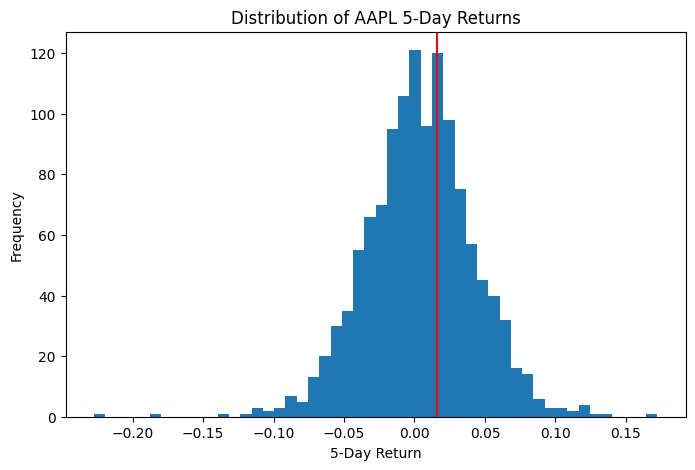

In [ ]:
# Graphing the results

HORIZON=5
r5 = model_df_nlp["AAPL_close"].pct_change(HORIZON).dropna()

plt.figure(figsize=(8,5))
plt.hist(r5, bins=50)
plt.axvline(expected_r, color='red')
plt.title("Distribution of AAPL 5-Day Returns")
plt.xlabel("5-Day Return")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Backtesting the model
bt_df = model_df_nlp_5d.copy()

# Excluding certain columns
X_all = bt_df.loc[:, rf_nlp_5d.feature_names_in_]

# Getting weekly probablities for every date
bt_df['prob_up_5d'] = rf_nlp_5d.predict_proba(X_all)[:, 1]

# Apply the threshold and decision rule
THRESHOLD = 0.55
model_df_nlp_5d['signal'] = (model_df_nlp_5d['prob_up_5d'] >= THRESHOLD).astype(int)

# Computing the realized 5-day forward return -- understand code a little more
HORIZON = 5
bt_df['return_5d'] = bt_df['AAPL_close'].pct_change(HORIZON)

# Drop rows with no future data and keep only every 5 weeks to avoid overlap
bt_df = bt_df.dropna(subset=['return_5d'])
bt_df['week_id'] = np.arange(len(bt_df)) // 5
bt_weekly = bt_df.groupby('week_id').last()

# Strategy vs. Buy-and-Hold returns
# Strategy selectively takes risk
# Buy-and-Hold always takes risk
bt_weekly['strategy_return'] = bt_weekly['signal'] * bt_weekly['return_5d']
bt_weekly['bh_return'] = bt_weekly['return_5d']

# Cumulative performance
bt_weekly['strategy_cum_return'] = (1 + bt_weekly['strategy_return']).cumprod()
bt_weekly['bh_cum_return'] = (1 + bt_weekly['bh_return']).cumprod()

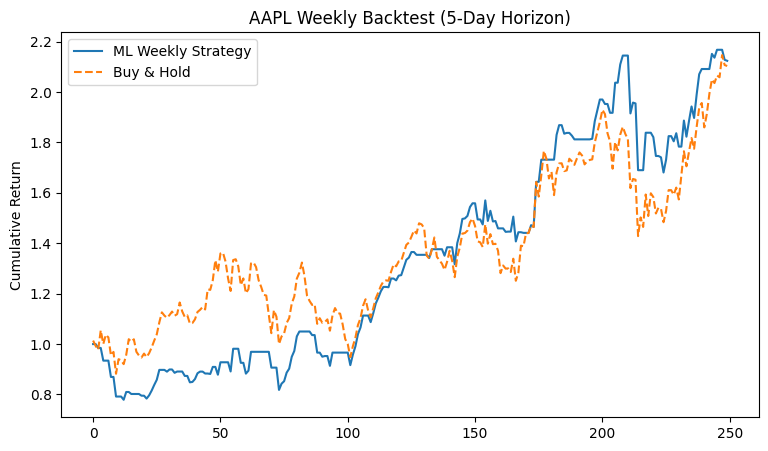

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(bt_weekly.index, bt_weekly['strategy_cum_return'], label='ML Weekly Strategy')
plt.plot(bt_weekly.index, bt_weekly['bh_cum_return'], linestyle='--', label='Buy & Hold')
plt.title("AAPL Weekly Backtest (5-Day Horizon)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()